In [109]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

In [110]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 10

In [150]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].diff()
        df_acc['y'] = df_tmp['y'].diff()
        df_acc['z'] = df_tmp['z'].diff()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n).mean()
        return self

    def plot(self, column_type ,option):
        self.low_filter(column_type, filter_num)
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.plot(column, option)
        else:
            if option == "low":
                column_type = column_type + '_low'
            plt.figure(figsize=(10, 5))
            plt.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            plt.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            plt.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            plt.legend()
            plt.title(column_type)
            plt.xlabel('time')
            plt.ylabel(column_type)
            plt.grid()
            plt.show()

In [151]:
# updownのデータを読み込む
walk = Data('walk_L')
walk.low_filter('all', filter_num)

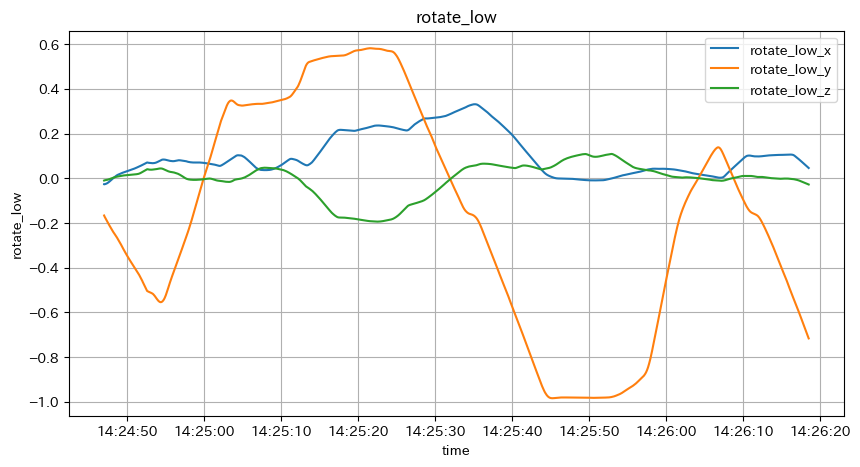

In [152]:
walk.plot('rotate', 'low')

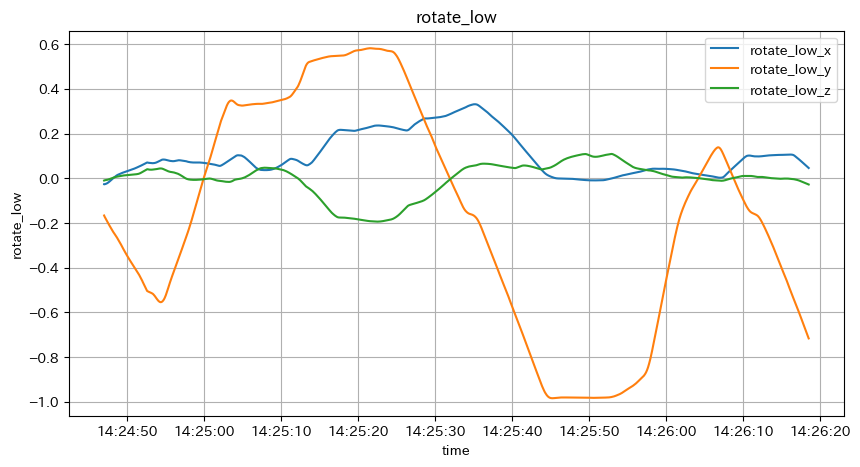

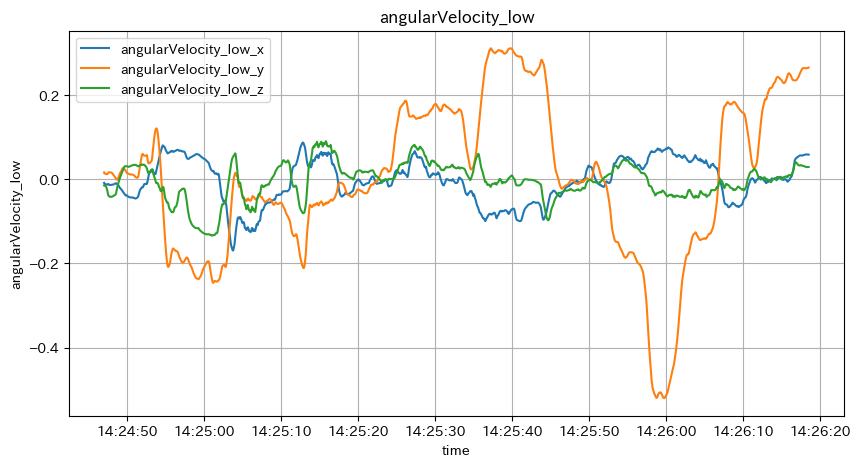

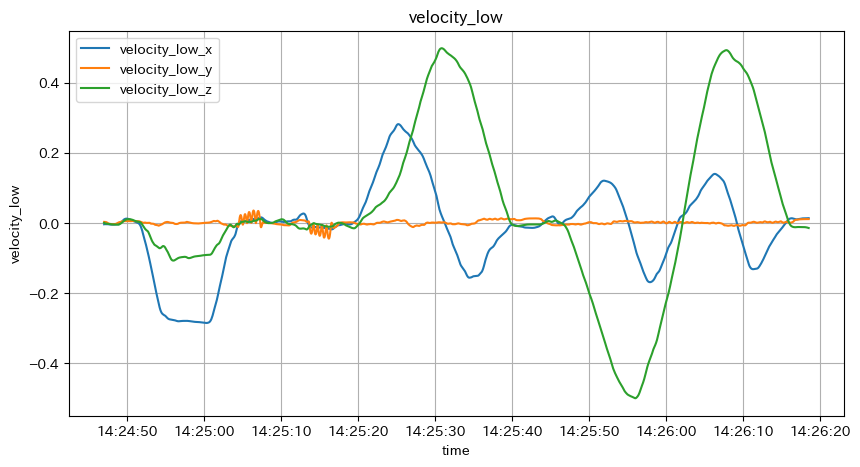

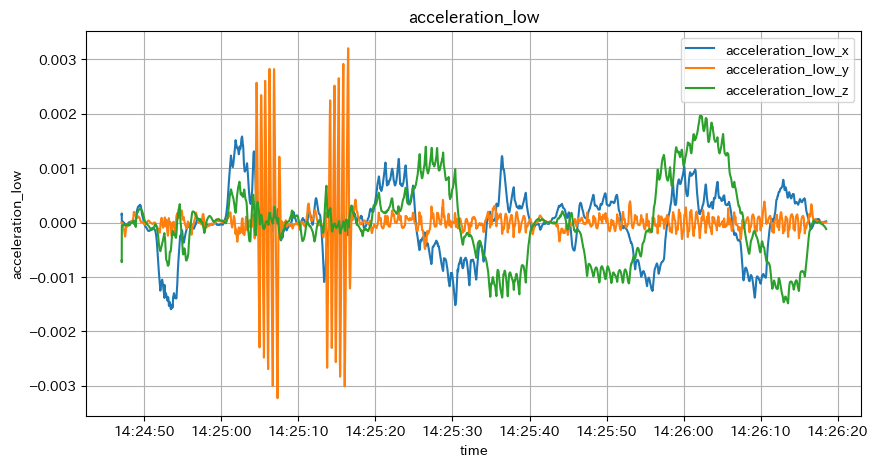

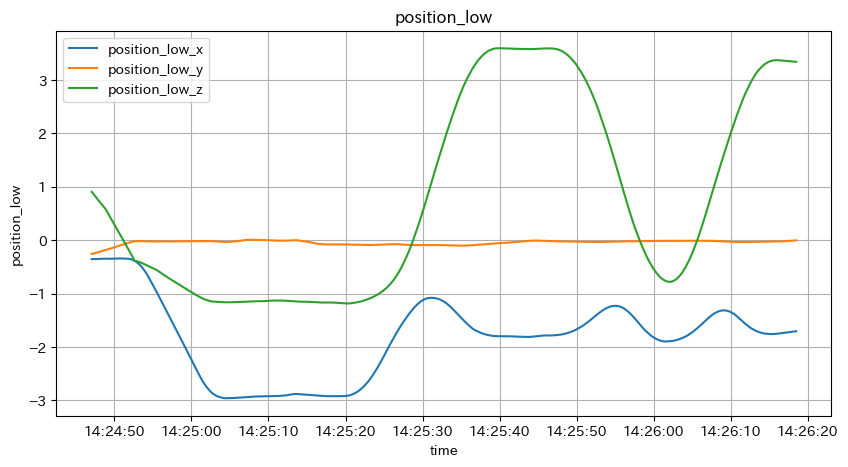

In [153]:
walk.plot('all', 'low')

In [ ]:
updown.plot('all', 'low')

KeyboardInterrupt: 